# Bi-GRUと忘却を用いた学習推定モデル  
- 必要なソフト：python ,R, ICL
    - Rのインストール：(https://www.r-project.org/)  
    - ICL(IRT Command Language)のインストール：(http://www.openirt.com/b-a-h/software/irt/icl/)   
- 当時実行した環境
    - R version 4.2.2 (2022-10-31 ucrt)  
    - Python 3.10.8
- 当時のPythonのパッケージのバージョン
    - keras                        2.11.0
    - matplotlib                   3.6.2
    - numpy                        1.23.4
    - pandas                       1.5.0
    - PypeR                        1.1.2
    - scipy                        1.9.2
    - tensorflow                   2.11.0
- ポイント
データのユーザid及びアイテムidは0から番号を振る．

In [1]:
import numpy as np
import pandas as pd
import pyper
import random
import datetime
import time
import pickle
import os
import math
import pprint
import csv
import tensorflow as tf
import keras as keras
from keras.layers import Input, Embedding, Concatenate, Activation, Dense, \
                                    Flatten, Dropout, Conv1D, Reshape, BatchNormalization,\
                                        GRU, Bidirectional,SpatialDropout1D, GaussianDropout, LSTM
from keras import Model
from keras.optimizers import Adam, Adamax
from keras.losses import MeanSquaredError
from keras.metrics import AUC
from keras.initializers import Constant, RandomUniform
from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
import os
# np.set_printoptions(suppress=True) すべての出力を表示したい場合

import keras.backend as K

print('Tensorflow version = {}'.format(tf.__version__))
print(os.getcwd())
from os import path
import sys
from scipy.linalg import toeplitz

rootdir = "Datasets"
print("current dir : {}".format(os.getcwd()))
print("rootdir : {}".format(rootdir) )

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"


Tensorflow version = 2.11.0
c:\Users\S_Hasegawa\OneDrive\ドキュメント\大枝研\Bi_GRU\Dynamic-Neural-Models-for-Knowledge-Tracing-main
current dir : c:\Users\S_Hasegawa\OneDrive\ドキュメント\大枝研\Bi_GRU\Dynamic-Neural-Models-for-Knowledge-Tracing-main
rootdir : Datasets


パラメータ群

In [2]:
ITEM = 200
SKILL = 5
USER = 500
RECORD = 100000
PL = 1
MAKE_DATA = False
H = 0.000001 # 忘却モデルのパラメータ（人口データ）
DIR_NAME = "12251412_1pl_100_5_100"

### 人工データ作成

スキルごとにデータ分割

In [3]:
# スキルごとのデータの分割
def div_skilldata(Q_matrix, data, file_path, item_n, skill_n, train_mode="all" ):
    Qt = Q_matrix.T
    item_index = [[i for i, e in enumerate(Qt[j]) if e == 1]for j in range(skill_n)]         # ITEM*SKILL(そのスキルが使用されているアイテム)
    skill_of_item = [[i for i, e in enumerate(Q_matrix[j]) if e == 1]for j in range(item_n)] # SKILL*ITEM(アイテムが所有するスキル)
    skill_list = [[]for i in range(skill_n)] # 2次元*SKILL
    user_index = [[]for i in range(skill_n)] # 1次元*SKILL
    #print(item_index)

    for record in range(len(data)):
        users = data[record][0]
        items = data[record][1]
        s = skill_of_item[items]
        for skill in s:
            # 既存ユーザ
            # 同じ問題を解いたら，最新の結果を反映させる
            if users in user_index[skill]:
                user_i = user_index[skill].index(users)
                skill_list[skill][user_i][item_index[skill].index(items)] = data[record][2]
            else : # 新規ユーザ
                user_index[skill].append(users)
                skill_list[skill].append([-1]*len(item_index[skill]))
                skill_list[skill][-1][item_index[skill].index(items)] = data[record][2]


    skill_list_str = [[]for i in range(skill_n)] # 2次元*SKILL

    # 文字列に変換
    for i in range(skill_n):
        for j in range(len(skill_list[i])):
            skill_list_str[i].append((''.join(map(str,skill_list[i][j]))).replace("-1", ' ')+' {}'.format(user_index[i][j])+'\n')
        with open(file_path+"skills/skill_{}_{}.dat".format(i, train_mode), "w") as f:
            f.writelines(skill_list_str[i])

    # スキルごとのユーザIDのインデックスを保存
    with open(file_path+"skill_index.dat", "wb")as f:
        pickle.dump(user_index, f)
    # スキルごとの問題数のリストを作成
    item_num = []
    for ii in item_index:
        item_num.append(len(ii))


    return item_num, item_index
 

         

Bi-GRU用にデータを変形

In [4]:
def data_forBigru(df, file_path, item_n, Q_matrix, train_or_test):
    #columns は ["user_id", "item_id", "result", "date"]

    user_pat_len = len(df["user_id"].unique())
    #print(user_pat_len)

    df_v = df.values # ndarrayの方が速いっぽいため，そちらに変更

    skill_of_item = [[i for i, e in enumerate(Q_matrix[j]) if e == 1]for j in range(item_n)] # SKILL*ITEM(アイテムが所有するスキル)
    bigru_data = [[[]for j in range(3)]for i in range(user_pat_len)] # 3次元*USER
    user_already = [] # ユーザが登録されたかどうかの判定用配列
    
    #---データを配列に代入---#
    for record in range(len(df)):
        user = df_v[record][0]
        if user not in user_already: #userが登録されていなかったら
            user_already.append(user)
            user_i = len(user_already)-1 # 新しいインデックス取得
            bigru_data[user_i][0].append(user)
            bigru_data[user_i][0].append(0)
        else:
            user_i = user_already.index(user)
        bigru_data[user_i][0][1]+=1
        for sk_i in skill_of_item[df_v[record][1]]: # 問題IDでは無く，その問題に含まれているスキルIDを格納する()
            bigru_data[user_i][1].append(sk_i)
            bigru_data[user_i][2].append(df_v[record][2])

    #---データを保存---# 
    with open(file_path+"data_forBigru_"+train_or_test+".csv", "w", newline='')as f:
        writer = csv.writer(f)
        for i in range(user_pat_len):
            writer.writerows(bigru_data[i])

 元データ作成

In [5]:
# Qマトリックスの作成
def make_Q_matrix():
    Q_matrix = np.random.rand(ITEM, SKILL)
    for i in range(ITEM):
        flag = 0 #全て0になるITEMを作成しないようにするためのフラグ
        for j in range(SKILL):
            if Q_matrix[i][j] >= 1.1: # ここの0.〇は，マルチスキルにする度合い.数が大きいほどマルチスキルになりにくい(0.0~1.0) 
                Q_matrix[i][j] = 1    # 1以上にすれば，間違いなくシングルスキルにできる．
                flag = 1
            else :
                Q_matrix[i][j] = 0
        # 全て0のITEMが出来てしまった場合，どこか一つを1にする
        if flag == 0:
            Q_matrix[i][random.randint(0, SKILL-1)] = 1
    
    return Q_matrix


# IRTのパラメータ(a,b)の設定
def make_IRTparameter(Q_matrix):
    # 項目パラメータの分布作成
    items = []
    skills = []
    for i in range(ITEM):
        skill  = [n for n, v in enumerate(Q_matrix[i]) if v == 1]
        if PL == 1:
            a = 1 # 1PLの場合，aは一定
        else :
            a = np.random.lognormal(0, np.sqrt(0.5)) # 対数正規分布
        b = np.random.normal(0, 2)      # 正規分布 
        items.append([a, b])
        skills.append(skill)
    return items, skills

# 特性値の増加(成長)
def grow_trait(trait, skill):
    trait[skill] += np.random.beta(10, 10) *10e-2
    #print("grow:",trait[skill])

# 特性値の減少(怠惰)
def decline_trait(trait, skill, b):
    trait[skill] -= np.random.beta(10, 10) * b*10e-2
    #print("decl:",trait[skill])


# 正解・不正解の作成
# (前の特性値)
def make_result(trait, item, skills_item, pre_data_date, now_data_date):
    prob = []
    for i, skill in enumerate(skills_item):
        if pre_data_date[i] != -1: # 前のデータが存在する場合
            pre_time = datetime.datetime.strptime(pre_data_date[i], "%Y-%m-%d %H:%M:%S")
            now_time = datetime.datetime.strptime(now_data_date, "%Y-%m-%d %H:%M:%S")
            t = int((now_time-pre_time).total_seconds()) # 前のデータとの差
            #print(t)
            generator = np.random.default_rng()
            """
            忘れの具合にエビングハウスの忘却曲線を取り入れるのもあり
            """
            b = 1.84/((math.log10(t/60))**(1.25)+1.84) # エビングハウスの忘却曲線

            """
            margin = generator.normal(loc=86400, scale=8000, size=1) # 忘れのマージン(一日の秒数を平均とする正規分布)
            margin = int(margin[0])
            grow_flag = False
            if margin > t: # 経過時間がマージンより小さかったら成長
                forget_model_t = margin-t
                grow_flag = True
            else :         # 経過時間がマージンより大きかったら怠惰
                forget_model_t = t-margin
            """
            #---時間から特性値を算出(時間は経過しているため，特性値は減る)---#    
            decline_trait(trait, skill, b)
            
            #---算出された特性値から正答確率を算出---#
            pl = (1 / (1+np.exp(-1.7*item[0]*(trait[skill]-item[1]))))
            forget = ((1+H*(t))**(-1*np.exp(-1*trait[skill]-item[1]))/(1+np.exp(-1.7*item[0]*(trait[skill]-item[1]))))
            prob.append(forget)
            grow_trait(trait, skill) #学習したので，特性値は増える． 

        else: #前のデータが存在しない場合 
            pl = (1 / (1+np.exp(-1.7*item[0]*(trait[skill]-item[1]))))
            prob.append(pl)
            #grow_trait(trait, skill, b)


    prob_mean = sum(prob)/len(prob)
    if prob_mean >= 0.5:
        return 1
    else:
        return 0 

# 特性値θの作成
def make_trait():
    trait = np.random.normal(0, 2, (USER, SKILL)) # 平均値，標準偏差，サイズ（100*5）
    return trait

# 前のデータを取得
def pre_data_index(user_pretest_user, skills_item_id, now_record):
    pre_index = []
    for skill_item in skills_item_id:
        pre_index.append(user_pretest_user[skill_item])
        user_pretest_user[skill_item] = now_record # インデックス更新
    return pre_index        

# 人口データの作成
def make_data():
    #---データの宣言---#
    data = []
    #data = np.zeros((USER, ITEM))
    Q_matrix = make_Q_matrix() # Qマトリックス作成
    items, skills = make_IRTparameter(Q_matrix) # IRTのパラメータ作成
    user_trait = make_trait()                   # 特性値作成
    user_pretest = np.full((USER, SKILL), -1)   # ユーザの，前回テストした日のインデックスを格納（初期は-1）
    
    #---フォルダ作成---##
    # 現在時刻の取得
    t_delta = datetime.timedelta(hours=9)
    JST = datetime.timezone(t_delta, 'JST')
    now = datetime.datetime.now(JST)
    d = now.strftime('%m%d%H%M') 
    file_path = "./Data/"+d+"_{}pl_{}_{}_{}".format(PL, ITEM, SKILL, USER)+'/'
    os.makedirs(file_path, exist_ok=True)
    os.makedirs(file_path+"skills/", exist_ok=True)
    os.makedirs(file_path+"irts/", exist_ok=True)
    # 初期の特性値を格納
    np.savetxt(file_path+"/user_trait_first.csv",user_trait, fmt='%.6f',delimiter=',')
   
    #---ユーザごとに，いちばん最初の学習時間を設定---#
    date = datetime.datetime(2021, 8, 1, 12, 0, 0)
    next_date = []
    for user in range(USER):
        next_date.append(date + datetime.timedelta(days=random.randint(0, 1),hours=random.randint(1, 12), minutes=random.randint(1, 60), seconds=random.randint(1, 60)))
        
    #---データ作成---#
    for record in range(RECORD):
        user_id = random.randint(0, USER-1)
        item_id = random.randint(0, ITEM-1)
        #print(record, user_id, item_id)
        date = next_date[user_id]
        next_date[user_id] = date+datetime.timedelta(days=random.randint(0, 1), hours=random.randint(1, 12), minutes=random.randint(1, 60), seconds=random.randint(1, 60))
        # 同一ユーザ・同一スキルに対する前のデータの取得
        pre_index = pre_data_index(user_pretest[user_id], skills[item_id], record)
        pre_data_date = []
        for pre_i in pre_index:
            if pre_i != -1:
                pre_data_date.append(data[pre_i][3]) # 前のdateを取得
            else:
                pre_data_date.append(-1) # 前のdateは無し

        #print(pre_index, pre_data_date)
        result = make_result(user_trait[user_id], items[item_id], skills[item_id], pre_data_date, str(date))
        #date_delta = datetime.timedelta(seconds=random.randint(1, 60))
        data.append([int(user_id), int(item_id), int(result), str(date)])
        """
        for skill_item in skills[item_id]:
            user_pretest[user_id][skill_item] = record
        """
    df = pd.DataFrame(data)
    df.columns = ["user_id", "item_id", "result", "date"]
    df = df.sort_values("date")
    
    
    #---ファイルに保存---#
    # データを訓練とテスト用に分割
    #train_i = int(RECORD*0.8)
    train_i_1 = int(RECORD*0.6)
    train_i_2 = int(RECORD*0.8)
    df_train = df[0:train_i_2]
    df_train1 = df[0:train_i_1]
    df_train2 = df[train_i_1:train_i_2]
    df_test = df[train_i_2:]
    #df_test = df[train_i:]
    df_train1.to_csv(file_path+"synthetic_data_train1.csv", index=None)
    df_train2.to_csv(file_path+"synthetic_data_train2.csv", index=None)
    df_train.to_csv(file_path+"synthetic_data_train.csv", index=None)
    df_test.to_csv(file_path+"synthetic_data_test.csv", index=None)

    data_forBigru(df_train1, file_path, ITEM, Q_matrix, "train1")
    data_forBigru(df_train2, file_path, ITEM, Q_matrix,"train2")
    data_forBigru(df_train, file_path, ITEM, Q_matrix,"train")
    data_forBigru(df_test, file_path, ITEM, Q_matrix,"test")

    # データ本体を保存
    df.to_csv(file_path+"synthetic_data.csv", index=None)
    # Q-マトリックスを保存
    np.savetxt(file_path+"Q_matrix.csv", Q_matrix, fmt='%d',delimiter=',')

    # スキルごとのデータの分割
    item_num, item_index = div_skilldata(Q_matrix, df.values, file_path, ITEM, SKILL)    
    with open(file_path+"item_num.dat", "wb")as f:
        pickle.dump(item_num, f)
    with open(file_path+"item_index.dat", "wb") as f:
        pickle.dump(item_index, f)
    np.savetxt(file_path+"/items.csv",items,fmt='%12.8f',delimiter=',')
    
    #np.savetxt(file_path+"/data.dat",data, fmt="%.0f", delimiter='')
    np.savetxt(file_path+"/user_trait.csv",user_trait, fmt='%.6f',delimiter=',')



    
    return Q_matrix, df, file_path, item_num, item_index


### IRT

In [6]:
def IRT_Estimate(file_path, i, item_i_num, train_mode="all"):

    # パラメータ推定
    os.chdir(file_path+"irts/")
    bat = open("IRT_wd_cmd.bat", 'w')
    tcl = open("IRT_icl_cmd.tcl", "w")
    bat_line = ["icl IRT_icl_cmd.tcl\n"]
    tcl_line = ["output -log_file irt_log.iclo\n", 
                "set_default_model_dichtomous {}PL\n".format(PL),
                "options -D 1.7\n",
                "allocate_items_dist {} -num_latent_dist_points 20\n".format(item_i_num),
                "read_examinees {}.dat {}i1\n".format("../skills/skill_"+str(i)+"_"+train_mode,item_i_num),
                "starting_values_dichotomous\n", 
                "EM_steps -max_iter 2000\n",
                "write_item_param irt_param_skill_{}_{}.iclp\n".format(i, train_mode),
                "release_items_dist\n"
                ]
    
    tcl.writelines(tcl_line)
    bat.writelines(bat_line)
    tcl.close()
    bat.close()
    os.system("IRT_wd_cmd.bat")
    os.chdir("../../../")

    # 特性値推定
    r = pyper.R()
    r.assign("file_name", file_path)
    r.assign("ITEM", str(item_i_num))
    r.assign("i", str(i))
    r.assign("PL", str(PL))
    r.assign("train_mode", str(train_mode))
    print(r("source('irt_params_forPy.R')"))
    trait = pd.DataFrame(r.get("theta"))

    return trait


In [7]:
#USE_W2V = True
USE_W2V = False 
emb_size = 150
#emb_size = 100

L = 10
max_epochs = 5
beta = 1e-3
 
mod =  'bigru_model'
spatd = None
gausd = None

num_hidden = [50,25]
batch_size = 32    

    
use_sigmoid = False
CREATE_NEW_DATA_SPLIT = True
global fold
    
#DATASET = 'assistment2009_corrected'
#DATASET = 'assist2009_updated'
#DATASET = 'fsaif1tof3'
#DATASET = 'assistment2012_13'
#DATASET = 'assistment2017'

max_v_auc = []

Function `printProgressBar`: function that prints progress bar in the console

In [8]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '',
                      decimals = 1, length = 100, fill = '█', printEnd = ""):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd, flush=True)
    # Print New Line on Complete
    if iteration == total: 
        print()


In [9]:
#Read file in 3-lines format and return `data` numpy array

def read_file_3lines(file):
    user_ids = []
    skill_ids = []
    correct = []
    
    with open(file, "r") as f:
        line = f.readline() # 1行目：学生IDとその生徒が解答した回数
        #print(type(line), line)   
        line_split = list(map(int, line.replace("\n","").split(",")))
        cnt = 0
        user_id = line_split[0]
        #print(user_id, line[1])
        try:
            num_responses = int(line_split[1])
            #num_responses = int(line_split[0])
        except:
            print('Error')
        user_ids += [user_id]*num_responses # Useridは上から順に1, 2, 3...
        while line:
            line = f.readline()
            if line=="":
                break
            line_split = list(map(int, line.replace("\n","").split(",")))
            #print(type(line_split[0]))
            cnt += 1
            if cnt%3 == 0:
                user_id = line_split[0]
                num_responses = int(line_split[1])
                #num_responses = int(line_split[0])
                user_ids += [user_id]*num_responses
            elif cnt%3 == 1:
                skill_ids += line_split
            elif cnt%3==2:
                correct += line_split
        user_ids = np.reshape(np.array(user_ids),[-1,1])
        num_unique_users = np.unique(user_ids[:,0]).shape[0]
        skill_ids = np.reshape(np.array(skill_ids).astype(int),[-1,1])
        correct = np.reshape(np.array(correct).astype(int),[-1,1])
        idx = np.reshape((correct==0) + (correct==1), [-1])
        data = np.hstack((user_ids[idx], skill_ids[idx], correct[idx]))
        return data, num_unique_users

In [10]:
#Read file in 3-lines format and return `data` numpy array

def read_file_3lines_forget(file, file_trait):
    user_ids = []
    skill_ids = []
    correct = []
    trait = []
    t_array = []
    with open(file_trait, "r") as ft:
        while True:
            line = ft.readline()
            if not line:
                break 
            try:
                line_split = list(map(float, line.replace("\n","").split(",")))
                t_array.append(line_split)
            except:
                t_array.append([0])

    with open(file, "r") as f:
        line = f.readline() # 1行目：学生IDとその生徒が解答した回数
        #print(type(line), line)   
        line_split = list(map(int, line.replace("\n","").split(",")))
        cnt = 0
        user_id = line_split[0]
        trait += t_array[user_id]
        #print(user_id, line[1])
        try:
            num_responses = int(line_split[1])
            #num_responses = int(line_split[0])
        except:
            print('Error')
        user_ids += [user_id]*num_responses 
        while line:
            line = f.readline()
            if line=="":
                break
            line_split = list(map(int, line.replace("\n","").split(",")))
            #print(type(line_split[0]))
            cnt += 1
            if cnt%3 == 0:
                user_id = line_split[0]
                trait += t_array[user_id]
                num_responses = int(line_split[1])
                #num_responses = int(line_split[0])
                user_ids += [user_id]*num_responses
            elif cnt%3 == 1:
                skill_ids += line_split
            elif cnt%3==2:
                correct += line_split

        user_ids = np.reshape(np.array(user_ids),[-1,1])
        num_unique_users = np.unique(user_ids[:,0]).shape[0]
        skill_ids = np.reshape(np.array(skill_ids).astype(int),[-1,1])
        trait = np.reshape(np.array(trait),[-1,1])
        correct = np.reshape(np.array(correct).astype(int),[-1,1])
        idx = np.reshape((correct==0) + (correct==1), [-1])
        data = np.hstack((user_ids[idx], skill_ids[idx], trait[idx],correct[idx]))
        return data, num_unique_users

In [11]:
def gen_inputs_targets(data, user_ids, N, prefix):
    printProgressBar(0, N, prefix = prefix, suffix = 'Complete', length = 50)
    
    x = None
    t = None
    start = True
    for i,student_id in enumerate(user_ids):
        # Make an array with all the data for this student
        # 時系列順にずらした入力を作っている
        student_data = data[data[:,0]==student_id]
        skill_hist = toeplitz(student_data[:,1],0.0*np.ones([1,L])) # テプリッツ行列に変換
        responses_hist = toeplitz(student_data[:,2],0.0*np.ones([1,L]))
        student_data = np.hstack((skill_hist,
                                np.fliplr(responses_hist)
                                ))
        if start:
            start = False
            x = student_data[1:,0:2*L-1]
            t = student_data[1:,2*L-1].reshape([-1,1])
        else:
            x = np.vstack((x, student_data[1:,0:2*L-1]))
            t = np.vstack((t, student_data[1:,2*L-1].reshape([-1,1])))
        printProgressBar(i+1, N, prefix = prefix, suffix = 'Complete', length = 50)        
    return x, t

In [12]:
def gen_inputs_targets_forget(data, user_ids, N, prefix):
    printProgressBar(0, N, prefix = prefix, suffix = 'Complete', length = 50)
    
    x = None
    t = None
    start = True

    for i,student_id in enumerate(user_ids):
        # Make an array with all the data for this student
        # 時系列順にずらした入力を作っている
        
        #print("FFFF")
        student_data = data[data[:,0]==student_id]
        skill_hist = toeplitz(student_data[:,1],0.0*np.ones([1,L])) # テプリッツ行列に変換
        trait_hist = toeplitz(student_data[:,2],0.0*np.ones([1,L])) # テプリッツ行列に変換
        responses_hist = toeplitz(student_data[:,3],0.0*np.ones([1,L]))
        student_data = np.hstack((skill_hist,trait_hist,
                                np.fliplr(responses_hist)
                                ))
        if start:
            start = False
            x = student_data[1:,0:3*L-1]
            t = student_data[1:,3*L-1].reshape([-1,1])
        else:
            x = np.vstack((x, student_data[1:,0:3*L-1]))
            t = np.vstack((t, student_data[1:,3*L-1].reshape([-1,1])))
        printProgressBar(i+1, N, prefix = prefix, suffix = 'Complete', length = 50)        
    return x, t

read_data

In [13]:
#Read Train-Test datasetd

def read_data_test(file_path, skill_num):

    train_file = path.join(file_path,"data_forBigru_train.csv")
    test_file = path.join(file_path,"data_forBigru_test.csv")


    spatd = 0.5
    gausd = 0.4

    #num_skills = skill_names.shape[0]
    num_skills = skill_num # スキル数
    # Add a zero row at the beginning
    embeddings = np.zeros([num_skills,emb_size])
    embeddings = np.vstack((np.zeros([1,emb_size]), embeddings))
        
    data_train, N_train = read_file_3lines(train_file)
    data_test, N_test = read_file_3lines(test_file)
    
    return data_train, data_test, embeddings, spatd, gausd

#file_path = "./Data/"+DIR_NAME+'/'

#read_data_test(file_path)

In [14]:
#Read Train-Test datasetd

def read_data_test_forget(file_path, skill_num, mode):

    train_file = path.join(file_path,"data_forBigru_train.csv")
    test_file = path.join(file_path,"data_forBigru_test.csv")

    if mode == "forget":
        train_trait_file = path.join(file_path,"train_trait_array.csv")
        test_trait_file = path.join(file_path,"test_trait_array.csv")
    if mode == "nonforget":
        train_trait_file = path.join(file_path,"train_trait_array_IRT.csv")
        test_trait_file = path.join(file_path,"test_trait_array_IRT.csv")
    
    spatd = 0.5
    gausd = 0.4

    #num_skills = skill_names.shape[0]
    num_skills = skill_num # スキル数
    # Add a zero row at the beginning
    embeddings = np.zeros([num_skills,emb_size])
    embeddings = np.vstack((np.zeros([1,emb_size]), embeddings))
        
    data_train, N_train = read_file_3lines_forget(train_file, train_trait_file)
    data_test, N_test = read_file_3lines_forget(test_file, test_trait_file)
    
    return data_train, data_test, embeddings, spatd, gausd

#file_path = "./Data/"+DIR_NAME+'/'

#read_data_test(file_path)

Callback

In [15]:
global keys
global key_val_acc
global key_val_auc
global key_acc
global key_auc

def get_key(keystart, list):
    for k in list:
        if k[:len(keystart)] == keystart:
            return k
    print("None")
    return None

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        global keys
        global key_val_acc
        global key_val_auc
        global key_acc
        global key_auc
        global filename
        if keys==[]:
            keys = list(logs.keys())
            key_val_acc = get_key('val_acc', keys)
            key_val_auc = get_key('val_auc', keys)
            key_acc = get_key('acc', keys)
            key_auc = get_key('auc', keys)
            filename = 'tdnn_w2v-f{:d}'.format(fold)\
                +'-e{epoch:02d}'\
                +'-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}'\
                +'-val_auc{'+key_val_auc+':.4f}'\
                +'.h5'
            checkpoint.filepath = filename
        print("Starting training; got log keys: {}".format(keys))
        
        return

In [16]:
def scheduler(epoch, beta):
    if epoch < 10:
        return beta
    else:
        return beta * tf.math.exp(0.1 * (10 - epoch))

callback1 = LearningRateScheduler(scheduler)

In [17]:
def Average(lst): 
    return sum(lst) / len(lst) 

## Bi-GRU model

In [18]:
def model_bigru(embeddings, spatd, gausd, num_hidden = [10], use_sigmoid=False):
    num_hidden = num_hidden+[1]    # add the extra output layer
    num_layers = len(num_hidden)
    # Inputs
    q_ids = Input(shape=[L], dtype=tf.int32)
    hist = Input(shape=[L-1])
    

    print("!!!!!!!!!!!! Using Random Skil name Embeddings!!!!")
    #initial_emb = tf.keras.initializers.RandomUniform(minval=-1/(emb_size*L),maxval=1/(emb_size*L))
    initial_emb = tf.keras.initializers.HeNormal()
    q = Embedding(embeddings.shape[0], emb_size, embeddings_initializer=initial_emb)(q_ids) 
    print(embeddings.shape[0])
    #initial_h_emb = tf.keras.initializers.RandomUniform(minval=-1/(emb_size*L), maxval=1/(emb_size*L))
    initial_h_emb = tf.keras.initializers.HeNormal()
    hist_emb = Embedding(2, emb_size, embeddings_initializer=initial_h_emb)(hist)
    
    
    print('q before conv:', q_ids.shape)
    print('hist before conv:', hist.shape)
    

    q = SpatialDropout1D(spatd)(q) 
    q_conv = Conv1D(filters=100, kernel_size=3, strides=1)(q)
    q_conv = BatchNormalization()(q_conv)    
    q_conv = Activation("relu")(q_conv)    
        
    hist_emb = SpatialDropout1D(spatd)(hist_emb)  
    hist_conv = Conv1D(filters=100, kernel_size=3, strides=1)(hist_emb)
    hist_conv = BatchNormalization()(hist_conv)    
    hist_conv = Activation("relu")(hist_conv)   
        
    x = Concatenate(axis=1)([q_conv, hist_conv])
    
    x = Bidirectional(GRU(units=64, return_sequences=False))(x)
    #x = GRU(units=64, return_sequences=False)(x)

    x = GaussianDropout(gausd)(x)
    
    for layer in range(num_layers):
        if layer == num_layers-1:
            activation = "sigmoid"            
        else:
            activation = "relu"                  
            x = Dense(num_hidden[layer], activation=activation)(x) 

    
    out = Dense(1, activation=activation)(x)
   
    model = Model(inputs=[q_ids, hist], outputs=out)
    
    return model

In [19]:
def model_bigru_forget(embeddings, spatd, gausd, num_hidden = [10], use_sigmoid=False):
    num_hidden = num_hidden+[1]    # add the extra output layer
    num_layers = len(num_hidden)
    # Inputs
    q_ids = Input(shape=[L], dtype=tf.int32)
    t_len = Input(shape=[1], dtype=tf.float32)
    hist = Input(shape=[L-1])
    

    print("!!!!!!!!!!!! Using Random Skil name Embeddings!!!!")
    #initial_emb = tf.keras.initializers.RandomUniform(minval=-1/(emb_size*L),maxval=1/(emb_size*L))
    initial_emb = tf.keras.initializers.HeNormal()
    q = Embedding(embeddings.shape[0], emb_size, embeddings_initializer=initial_emb)(q_ids) 
    print(embeddings.shape[0])
    #initial_h_emb = tf.keras.initializers.RandomUniform(minval=-1/(emb_size*L), maxval=1/(emb_size*L))
    initial_h_emb = tf.keras.initializers.HeNormal()
    hist_emb = Embedding(2, emb_size, embeddings_initializer=initial_h_emb)(hist)
    
    
    print('q before conv:', q_ids.shape)
    print('hist before conv:', hist.shape)
    

    q = SpatialDropout1D(spatd)(q) 
    q_conv = Conv1D(filters=100, kernel_size=3, strides=1)(q)
    q_conv = BatchNormalization()(q_conv)    
    q_conv = Activation("relu")(q_conv)    
        
    hist_emb = SpatialDropout1D(spatd)(hist_emb)  
    hist_conv = Conv1D(filters=100, kernel_size=3, strides=1)(hist_emb)
    hist_conv = BatchNormalization()(hist_conv)    
    hist_conv = Activation("relu")(hist_conv)   
        
    x = Concatenate(axis=1)([q_conv, hist_conv])
    
    x = Bidirectional(GRU(units=64, return_sequences=False))(x)
    #x = GRU(units=64, return_sequences=False)(x)

    x = GaussianDropout(gausd)(x)
    
    for layer in range(num_layers):
        if layer == num_layers-1:
            activation = "sigmoid"            
        else:
            activation = "relu"                  
            x = Dense(num_hidden[layer], activation=activation)(x)     

    x = Concatenate()([x, t_len])    
    
    out = Dense(1, activation=activation)(x)
   
    model = Model(inputs=[q_ids, t_len, hist], outputs=out)
    
    return model

# main(Train-Test)

In [20]:
# Train Test
def BiGRU_main(file_path, skill_num):
    f_name = file_path.strip("./Data/")
    print(" =============== START THE EXPERIMENT ============")
    print("~~~~~~~~~~~~~~~DATASET {} ~~~~~~~~~~~".format(file_path))
    max_test_auc = []

    data_file = path.join(file_path,"BiGRU_normal_{}_no_w2v_3lines_L{}_emb_size={}.npz".format(f_name,L,emb_size))

    data_train, data_test, embeddings, spatd, gausd = read_data_test(file_path, skill_num)
    skill_ids = np.unique(np.hstack((
        data_train[:,1],
        data_test[:,1]
        )))
    num_skills = len(skill_ids)
    train_user_ids = np.unique(data_train[:,0]) # idはユーザ数
    test_user_ids = np.unique(data_test[:,0])
    N_train = len(train_user_ids)
    N_test = len(test_user_ids)
    num_students = N_train + N_test

    print('Number of skills: {}'.format(num_skills))
    print('Number of train students: {}'.format(N_train))
    print('Number of test students: {}'.format(N_test))
    print('(total: {})'.format(num_students))

    # ### Generate `x_train`, `x_test`, `t_train`, `t_test`  
    # Every student `stud_id` has a sequence of responses `correct[0], correct[1],..., correct[T-1]` for some skill `skill_id`. The length `T` of the sequence depends on the student and the skill.   
    # Every row of `x_train` or `x_test` contains the `student_id`, the `skill_id` and the response `correct[t]` for some time `t`. In addition to that it also includes the history of length `L` of previous responses `correct[t-1],..., correct[t-L]`. These responses *must* correspond to the same student and the same skill as time `t`. If history is shorter than `L` then the missing entries are filled with `0`.
        
    if not path.exists(data_file):
    #if True:
        #Generate Training, Validation and Testing data
        print("!!not!!")
        x_train, t_train = gen_inputs_targets(data_train,
                                train_user_ids, N_train, 'Train set:')
        x_test, t_test = gen_inputs_targets(data_test,
                                test_user_ids, N_test, 'Test set:')
        

        np.savez(data_file, \
                embeddings = embeddings, \
                x_train = x_train, \
                x_test = x_test, \
                t_train = t_train, \
                t_test = t_test, \
                train_user_ids = train_user_ids, \
                test_user_ids = test_user_ids, \
                N_train = N_train, \
                N_test = N_test, \
                num_skills = num_skills, \
                num_students = num_students)    

    else:
        print("!!exist!!")  
        data_split = np.load(data_file)
        embeddings = data_split['embeddings']
        x_train = data_split['x_train']
        x_test = data_split['x_test']
        t_train = data_split['t_train']
        t_test = data_split['t_test']
        train_user_ids = data_split['train_user_ids']
        test_user_ids = data_split['test_user_ids']
        N_train = data_split['N_train']
        N_test = data_split['N_test']
        num_skills = data_split['num_skills']
        num_students = data_split['num_students']
        
    #Train the model
    acc_test_base = np.sum(t_test==1)/t_test.shape[0]
    print('Baseline test accuracy = {}'.format(acc_test_base))   
    print("==================================================")

    """    
    print("GGGGGGGGGGGGGGGGGGGGGGGGGGG")
    print(x_train.shape)
    #np.savetxt("tt.txt", x_train)
    print("GGGGGGGGGGGGGGGGGGGGGGGGGGG")
    """
    print('L = {}, emb_size = {}, hidden={}, spatial dropout = {}, gaussian dropout = {}'.format(
                L, emb_size, num_hidden, spatd, gausd))

    try:        
        del model 
        K.clear_session()
    except:
        print("no model to delete")
        

    print("~~~~~~~~~~Train Bi-GRU MODEL~~~~~~~~")
    model = model_bigru(embeddings=embeddings, spatd=spatd, gausd=gausd, num_hidden=num_hidden, use_sigmoid=use_sigmoid)   
    

    model.summary()
    model.compile(optimizer=Adam(learning_rate=beta), \
        loss= 'binary_crossentropy', \
        metrics=['accuracy', AUC()])

    history = model.fit([x_train[:,:L].astype(int), x_train[:,L:]], t_train, \
                        validation_data=([x_test[:,:L].astype(int), x_test[:,L:]],t_test), \
                        epochs = max_epochs, \
                        batch_size=batch_size, \
                        verbose=1, \
                        callbacks=callback1) # callback1によるエポックごとの学習率の変化(adam)



    model_title="{}_L={}_embsize={}_w2v={}_layers={}_model={}.png".format( \
            f_name, L, emb_size, False, num_hidden,mod)

    model_file = path.join(file_path,model_title)
    tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)    

    keys = history.history.keys()
    key_val_acc = get_key('val_acc', keys)
    key_val_auc = get_key('val_auc', keys)
    key_acc = get_key('acc', keys)
    key_auc = get_key('auc', keys)


    print("!!!!!!!!!!!!!!!!! TEST RESULTS !!!!!!!!!!!!!!!!!!!!!")
    all_test_auc = np.array(history.history[key_val_auc])
    max_test_auc.append(max(all_test_auc))
    av_test_auc = Average(all_test_auc)

    print(" =============== RESULTS OF EXPERIMENT  ============")
    print("Max test auc  is {} ".format(max(all_test_auc)))
    print('Average test auc  is {} '.format(av_test_auc))

    print("~~~~~EVALUATION RESULTS ~~~~~~~")
    model.evaluate([x_test[:,:L].astype(int), x_test[:,L:].astype(int)],
                                t_test,
                        batch_size=batch_size,
                        verbose=1)


    # プロット
    plt.figure(figsize=(9,6))
    ep = np.arange(1,max_epochs+1)
    plt.plot(ep, history.history[key_val_auc], 'r')
    plt.xticks(np.arange(0,max_epochs+1,5, dtype=np.int))
    plt.plot(ep, history.history[key_auc], 'b')
    plt.plot(ep, history.history[key_val_acc], 'r:')
    plt.plot(ep, history.history[key_acc], 'b:')
    plt.legend(['test.auc', 'auc', 'test.acc', 'acc'])
    plt.grid(b=True)    

    title="model={},DATASET={}, L={}, embsize={}, w2v={}, layers={}".format(
                mod, file_path, L, emb_size, False, num_hidden)
    plt.title(title)
    plt.show()

    # --- 新規データに対する予想 --- #
    preds = model.predict([x_test[:,:L].astype(int),x_test[:,L:].astype(int)],verbose=1)

    print('BiGru predictions')
    print(preds)    
    preds.tofile(file_path+ "/BiGru_predictions.csv",sep=',')
    preds_bin = preds
    preds_bin[preds_bin > 0.5] = 1.0
    preds_bin[preds_bin <= 0.5] = 0.0
    print("BiGru binary predictions")
    print(preds_bin)    
    preds_bin.tofile(file_path+ "/BiGru_binary_predictions.csv",sep=',')
    print('BiGru targets')
    print(t_test)

In [21]:
# Train Test
def BiGRU_forget_main(file_path, skill_num, mode = "forget"):
    f_name = file_path.strip("./Data/")
    print(" =============== START THE EXPERIMENT ============")
    print("~~~~~~~~~~~~~~~DATASET {} ~~~~~~~~~~~".format(file_path))
    max_test_auc = []

    data_file = path.join(file_path,"BiGRU_forget_{}_no_w2v_3lines_L{}_emb_size={}.npz".format(f_name,L,emb_size))

    data_train, data_test, embeddings, spatd, gausd = read_data_test_forget(file_path, skill_num, mode)
    skill_ids = np.unique(np.hstack((
        data_train[:,1],
        data_test[:,1]
        )))
    num_skills = len(skill_ids)
    train_user_ids = np.unique(data_train[:,0]) # idはユーザ数
    test_user_ids = np.unique(data_test[:,0])
    N_train = len(train_user_ids)
    N_test = len(test_user_ids)
    num_students = N_train + N_test

    print('Number of skills: {}'.format(num_skills))
    print('Number of train students: {}'.format(N_train))
    print('Number of test students: {}'.format(N_test))
    print('(total: {})'.format(num_students))

    # ### Generate `x_train`, `x_test`, `t_train`, `t_test`  
    # Every student `stud_id` has a sequence of responses `correct[0], correct[1],..., correct[T-1]` for some skill `skill_id`. The length `T` of the sequence depends on the student and the skill.   
    # Every row of `x_train` or `x_test` contains the `student_id`, the `skill_id` and the response `correct[t]` for some time `t`. In addition to that it also includes the history of length `L` of previous responses `correct[t-1],..., correct[t-L]`. These responses *must* correspond to the same student and the same skill as time `t`. If history is shorter than `L` then the missing entries are filled with `0`.
        
    if not path.exists(data_file):
    #if True:
        #Generate Training, Validation and Testing data
        print("!!not!!")
        x_train, t_train = gen_inputs_targets_forget(data_train,
                                train_user_ids, N_train, 'Train set:')
        x_test, t_test = gen_inputs_targets_forget(data_test,
                                test_user_ids, N_test, 'Test set:')
        

        np.savez(data_file, \
                embeddings = embeddings, \
                x_train = x_train, \
                x_test = x_test, \
                t_train = t_train, \
                t_test = t_test, \
                train_user_ids = train_user_ids, \
                test_user_ids = test_user_ids, \
                N_train = N_train, \
                N_test = N_test, \
                num_skills = num_skills, \
                num_students = num_students)    

    else:
        print("!!exist!!")  
        data_split = np.load(data_file)
        embeddings = data_split['embeddings']
        x_train = data_split['x_train']
        x_test = data_split['x_test']
        t_train = data_split['t_train']
        t_test = data_split['t_test']
        train_user_ids = data_split['train_user_ids']
        test_user_ids = data_split['test_user_ids']
        N_train = data_split['N_train']
        N_test = data_split['N_test']
        num_skills = data_split['num_skills']
        num_students = data_split['num_students']
        
    #Train the model
    acc_test_base = np.sum(t_test==1)/t_test.shape[0]
    print('Baseline test accuracy = {}'.format(acc_test_base))   
    print("==================================================")


    #print("GGGGGGGGGGGGGGGGGGGGGGGGGGG")
    #print(x_train)
    #x_train.tofile("tt.txt")
    #print("GGGGGGGGGGGGGGGGGGGGGGGGGGG")

    print('L = {}, emb_size = {}, hidden={}, spatial dropout = {}, gaussian dropout = {}'.format(
                L, emb_size, num_hidden, spatd, gausd))

    try:        
        del model 
        K.clear_session()
    except:
        print("no model to delete")
        

    print("~~~~~~~~~~Train Bi-GRU MODEL~~~~~~~~")
    model = model_bigru_forget(embeddings=embeddings, spatd=spatd, gausd=gausd, num_hidden=num_hidden, use_sigmoid=use_sigmoid)   
    

    model.summary()
    model.compile(optimizer=Adam(learning_rate=beta), \
        loss= 'binary_crossentropy', \
        metrics=['accuracy', AUC()])

    history = model.fit([x_train[:,:L].astype(int), x_train[:,2*L-1].astype(float), x_train[:,2*L:]], t_train, \
                        validation_data=([x_test[:,:L].astype(int),x_test[:,2*L-1].astype(float), x_test[:,2*L:]],t_test), \
                        epochs = max_epochs, \
                        batch_size=batch_size, \
                        verbose=1, \
                        callbacks=callback1) # callback1によるエポックごとの学習率の変化(adam)



    model_title="BiGRU_forget_{}_L={}_embsize={}_w2v={}_layers={}_model={}.png".format( \
            f_name, L, emb_size, False, num_hidden,mod)

    model_file = path.join(file_path,model_title)
    tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)    

    keys = history.history.keys()
    key_val_acc = get_key('val_acc', keys)
    key_val_auc = get_key('val_auc', keys)
    key_acc = get_key('acc', keys)
    key_auc = get_key('auc', keys)


    print("!!!!!!!!!!!!!!!!! TEST RESULTS !!!!!!!!!!!!!!!!!!!!!")
    all_test_auc = np.array(history.history[key_val_auc])
    max_test_auc.append(max(all_test_auc))
    av_test_auc = Average(all_test_auc)

    print(" =============== RESULTS OF EXPERIMENT  ============")
    print("Max test auc  is {} ".format(max(all_test_auc)))
    print('Average test auc  is {} '.format(av_test_auc))

    print("~~~~~EVALUATION RESULTS ~~~~~~~")
    model.evaluate([x_test[:,:L].astype(int), x_test[:,2*L-1], x_test[:,2*L:].astype(int)],
                                t_test,
                        batch_size=batch_size,
                        verbose=1)


    # プロット
    plt.figure(figsize=(9,6))
    ep = np.arange(1,max_epochs+1)
    plt.plot(ep, history.history[key_val_auc], 'r')
    plt.xticks(np.arange(0,max_epochs+1,5, dtype=np.int))
    plt.plot(ep, history.history[key_auc], 'b')
    plt.plot(ep, history.history[key_val_acc], 'r:')
    plt.plot(ep, history.history[key_acc], 'b:')
    plt.legend(['test.auc', 'auc', 'test.acc', 'acc'])
    plt.grid(b=True)    

    title="model={},DATASET={}, L={}, embsize={}, w2v={}, layers={}".format(
                mod, file_path, L, emb_size, False, num_hidden)
    plt.title(title)
    plt.show()

    # --- 新規データに対する予想 --- #
    preds = model.predict([x_test[:,:L].astype(int),x_test[:,2*L-1].astype(int),x_test[:,2*L:].astype(int)],verbose=1)

    print('BiGru predictions')
    print(preds)    
    preds.tofile(file_path+ "/BiGru_predictions.csv",sep=',')
    preds_bin = preds
    preds_bin[preds_bin > 0.5] = 1.0
    preds_bin[preds_bin <= 0.5] = 0.0
    print("BiGru binary predictions")
    print(preds_bin)    
    preds_bin.tofile(file_path+ "/BiGru_binary_predictions.csv",sep=',')
    print('BiGru targets')
    print(t_test)

In [22]:
#BiGRU_main(file_path, skill_n)


In [23]:
#BiGRU_forget_main(file_path, skill_n)


In [24]:
# 作業用
ITEM = 400
SKILL = 10
USER = 5000
RECORD = 400000
PL = 1
MAKE_DATA = False
H = 0.000001 # 忘却モデルのパラメータ（人口データ）
DIR_NAME = "12251412_1pl_100_5_100"

# Main   

In [25]:
# ファイル読み込み
MAKE_DATA = False
#MAKE_DATA = True
DIR_NAME = "01181519_1pl_400_10_5000"
# ファイル作成
if MAKE_DATA:
    print("Data makeing...")
    Q_matrix ,df, file_path, item_num, item_index = make_data()
    print("Data makeing Complete!")
    print()
# ファイル読み込み
else :
    print("Deta roading...")
    file_path = "./Data/"+DIR_NAME+'/'
    Q_matrix = np.loadtxt(file_path+"Q_matrix.csv", delimiter=',', dtype = int)
    df = pd.read_csv(file_path+"synthetic_data.csv")
    with open(file_path+"item_num.dat", "rb")as f:
        item_num = pickle.load(f)
    with open(file_path+"item_index.dat", "rb")as f:
        item_index = pickle.load(f)
    print("Data roading Complete!")
    print()
#print(item_num)
print()
print("Data>",file_path)
print()
print("IRT Estimating...")


user_n = len(df["user_id"].unique()) # 生徒の数
item_n = Q_matrix.shape[0]    # 問題の種類　
skill_n = Q_matrix.shape[1]   # スキルの種類

skill_of_item = [[i for i, e in enumerate(Q_matrix[j]) if e == 1]for j in range(item_n)] # SKILL*ITEM(アイテムが所有するスキル)

# ---通常のBiGRU--- #
#BiGRU_main(file_path, skill_n)
#DIR_NAME = "12241434_1pl_100_5_100"
df_train = pd.read_csv(file_path+"synthetic_data_train.csv")
df_train1 = pd.read_csv(file_path+"synthetic_data_train1.csv")
df_train2 = pd.read_csv(file_path+"synthetic_data_train2.csv")
df_test = pd.read_csv(file_path+"synthetic_data_test.csv")

# 特性値の推定用にtrain1を使用
#print(df)
div_skilldata(Q_matrix, df_train1.values, file_path, item_n, skill_n, "train1")    


skill_trait = [[]for i in range(skill_n)] # 2次元*SKILL
for i in range(Q_matrix.shape[1]):
    IRT_Estimate(file_path, i, item_num[i]) # 問題の困難度を推定
    skill_trait[i] = IRT_Estimate(file_path, i, item_num[i], "train1") # 被験者の初期特性値を推定   
print("IRT Estimating Complete!")



Deta roading...
Data roading Complete!


Data> ./Data/01181519_1pl_400_10_5000/

IRT Estimating...
try({source('irt_params_forPy.R')})
Loading required package: sm
Package 'sm', version 2.2-5.7: type help(sm) for summary information
Loading required package: ltm
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:sm':

    muscle

Loading required package: msm
Loading required package: polycor

Attaching package: 'psych'

The following object is masked from 'package:irtoys':

    sim

The following object is masked from 'package:ltm':

    factor.scores

The following object is masked from 'package:polycor':

    polyserial

           est   sem
   [1,]  2.651 0.665
   [2,] -1.174 0.742
   [3,] -0.072 0.625
   [4,] -0.574 0.710
   [5,]  1.717 0.570
   [6,] -0.424 0.641
   [7,]  1.566 0.740
   [8,] -1.067 0.756
   [9,] -1.180 0.735
  [10,] -0.870 0.804
  [11,] -1.060 0.752
  [12,]  1.303 0.635
  [13,] -0.939 0.579
  [14,] -0.603 0.848


In [26]:
def train_irtparam_matrix(file_path, df_train1, item_index, skills_user_index, user_n, item_n, skill_n):
    a_mat = np.zeros((item_n, skill_n))
    b_mat = np.zeros((item_n, skill_n))
    trait_mat = np.zeros((user_n, skill_n))
    
    for s_n in range(skill_n):
        i = 0
        with open(file_path+"irts/"+"irt_param_skill_{}_all.iclp".format(s_n)) as f:
            while(True):
                line = f.readline()
                if not line:
                    break
                line = line.split()
                a = float(line[1])
                b = float(line[2])
                a_mat[item_index[s_n][i]][s_n] = a
                b_mat[item_index[s_n][i]][s_n] = b
                i += 1
        
        i = 0
        with open(file_path+"irts/"+"trait_{}_train1.txt".format(s_n)) as f:
            line = f.readline()
            while(True):
                line = f.readline()
                if not line:
                    break
                line = line.split()
                trait = float(line[1])
                #print(trait)
                trait_mat[skills_user_index[s_n][i]][s_n] = trait
                i += 1


    return trait_mat, a_mat, b_mat

In [27]:
# 正解・不正解の作成
# (前の特性値)
def trait_change_forget(trait_mat, user, a_item, b_item, skills_item, pre_data_date, now_data_date):

    for i, skill in enumerate(skills_item):
        trait = []
        if pre_data_date[i] != -1: # 前のデータが存在する場合
            pre_time = datetime.datetime.strptime(pre_data_date[i], "%Y-%m-%d %H:%M:%S")
            now_time = datetime.datetime.strptime(now_data_date, "%Y-%m-%d %H:%M:%S")
            t = int((now_time-pre_time).total_seconds()) # 前のデータとの差
            #print(t)
            generator = np.random.default_rng()
   
            b = 1.84/((math.log10(t/60))**(1.25)+1.84) # エビングハウスの忘却曲線

            #---時間から特性値を算出(時間は経過しているため，特性値は減る)---#    
            trait_mat[user][skill] -= np.random.beta(10, 10) * b*10e-2
            trait.append(trait_mat[user][skill])
            
            #---算出された特性値から正答確率を算出---#
            trait_mat[user][skill] += np.random.beta(10, 10) *10e-2#学習したので，特性値は増える． 

        else: #前のデータが存在しない場合 
            trait.append(trait_mat[user][skill])
            #grow_trait_change(trait, skill, b)

        return trait_mat, trait

 

# 前のデータを取得
def pre_data_index(user_pretest_user, skills_item_id, now_record):
    pre_index = []
    for skill_item in skills_item_id:
        pre_index.append(user_pretest_user[skill_item])
        user_pretest_user[skill_item] = now_record # インデックス更新
    return user_pretest_user, pre_index        

def trait_change(trait_mat, a_mat, b_mat, skill_of_item, df_train2, df_test, user_n, item_n, skill_n):
    trait_change_mat_train2 = [[]for i in range(user_n)] # 1次元(時系列)*user_n
    trait_change_mat_test = [[]for i in range(user_n)] # 1次元(時系列)*user_n
    df_trait = pd.concat([df_train2, df_test]).values # train2とtestを結合(配列化)
    df_trait_len = len(df_trait) 
    df_train2_len = len(df_train2)
    df_test_len = len(df_test)
    user_pretest = np.full((user_n, skill_n), -1)   # ユーザの，前回テストした日のインデックスを格納（初期は-1）
    #print(user_pretest[196])
    
    for record in range(df_trait_len):
        user = df_trait[record][0]
        item = df_trait[record][1]
        date = df_trait[record][3]
        
        # 同一ユーザ・同一スキルに対する前のデータの取得
        user_pretest[user], pre_index = pre_data_index(user_pretest[user], skill_of_item[item], record)
        pre_data_date = []
        for pre_i in pre_index:
            if pre_i != -1:
                pre_data_date.append(df_trait[pre_i][3]) # 前のdateを取得
            else:
                pre_data_date.append(-1) # 前のdateは無し
                user = df_trait[record][0]

        #print(pre_index, pre_data_date)
        trait_mat, change_trait = trait_change_forget(trait_mat, user, a_mat[item],b_mat[item], skill_of_item[item], pre_data_date, date)
        for ct in change_trait:
            if record < df_train2_len:
                trait_change_mat_train2[user].append(ct)
            else:
                trait_change_mat_test[user].append(ct)

    return trait_change_mat_train2, trait_change_mat_test
        


In [28]:
# ---特性値行列と難易度行列を作成--- # 
with open(file_path+"skill_index.dat", "rb")as f:
    skills_user_index = pickle.load(f)
trait_mat, a_mat, b_mat = train_irtparam_matrix(file_path, df_train1, item_index, skills_user_index, user_n, item_n, skill_n)
print(trait_mat)
trait_mat_train = [[]for i in range(user_n)]
trait_mat_test = [[]for i in range(user_n)]
trait_change_mat_train = [[]for i in range(user_n)] # 1次元(時系列)*user_n
#trait_array_test = [[]for i in range(user_n)] # 1次元(時系列)*user_n

# 比較の為に，忘却なしのIRTのための特性値の列
df_train_v = df_train.values
for record in range(len(df_train_v)):
    #print(df_train1_v[record][1])
    for sk in skill_of_item[df_train_v[record][1]]:
        #print(sk)
        trait_mat_train[df_train_v[record][0]].append(trait_mat[df_train_v[record][0]][sk])
df_test_v = df_test.values
for record in range(len(df_test_v)):
    #print(df_train1_v[record][1])
    for sk in skill_of_item[df_test_v[record][1]]:
        #print(sk)
        trait_mat_test[df_test_v[record][0]].append(trait_mat[df_test_v[record][0]][sk])


df_train1_v = df_train1.values
# 提案手法における特性値推定用に抽出した訓練データ1
for record in range(len(df_train1_v)):
    #print(df_train1_v[record][1])
    for sk in skill_of_item[df_train1_v[record][1]]:
        #print(sk)
        trait_change_mat_train[df_train1_v[record][0]].append(trait_mat[df_train1_v[record][0]][sk])


print(user_n, item_n, skill_n)

# ---問題の難易度と時間から特性値の推移を予測--- #
trait_change_mat_train2, trait_change_mat_test =  trait_change(trait_mat, a_mat, b_mat, skill_of_item,  df_train2, df_test, user_n, item_n, skill_n) 

df_train2_v = df_train2.values

for record in range(user_n):
    trait_change_mat_train[record].extend(trait_change_mat_train2[record])

print(len(trait_change_mat_train[332]))
print(trait_change_mat_test[80])

[[-1.226 -0.842  1.884 ... -0.69  -0.266 -0.587]
 [ 0.976 -0.953  1.921 ...  1.637  1.372 -0.723]
 [-0.121  1.664 -0.623 ... -1.043  1.19   0.   ]
 ...
 [-0.69   0.059  0.26  ...  1.443 -0.378  0.399]
 [-1.138  0.812 -0.113 ... -0.695  2.398  0.369]
 [ 1.024  0.207  0.197 ...  0.116  1.935 -0.473]]
5000 400 10
64
[-0.765, 1.0026373852106665, 0.22219229331573487, 1.0639601041202682, -1.044, -1.4281587636870263, -0.28648070387348473]


In [29]:

#---比較モデル（忘れなし）---#
# 特性値の例の列を保存
with open(file_path+'train_trait_array_IRT.csv', 'wt', encoding='utf-8', newline='') as f:
    # ライター（書き込み者）を作成
    writer = csv.writer(f)
    for record in range(user_n):
    # ライターでデータ（リスト）をファイルに出力
        writer.writerow(trait_mat_train[record])

with open(file_path+'test_trait_array_IRT.csv', 'wt', encoding='utf-8', newline='') as f:
    # ライター（書き込み者）を作成
    writer = csv.writer(f)
    for record in range(user_n):
    # ライターでデータ（リスト）をファイルに出力
        writer.writerow(trait_mat_test[record])





#---提案モデル（忘れあり）---#
# 特性値の例の列を保存
with open(file_path+'train_trait_array.csv', 'wt', encoding='utf-8', newline='') as f:
    # ライター（書き込み者）を作成
    writer = csv.writer(f)
    for record in range(user_n):
    # ライターでデータ（リスト）をファイルに出力
        writer.writerow(trait_change_mat_train[record])

with open(file_path+'test_trait_array.csv', 'wt', encoding='utf-8', newline='') as f:
    # ライター（書き込み者）を作成
    writer = csv.writer(f)
    for record in range(user_n):
    # ライターでデータ（リスト）をファイルに出力
        writer.writerow(trait_change_mat_test[record])


 =============== START THE EXPERIMENT ============
~~~~~~~~~~~~~~~DATASET ./Data/01181519_1pl_400_10_5000/ ~~~~~~~~~~~
Number of skills: 10
Number of train students: 5000
Number of test students: 4636
(total: 9636)
!!exist!!
Baseline test accuracy = 0.3098561647470941
L = 10, emb_size = 150, hidden=[50, 25], spatial dropout = 0.5, gaussian dropout = 0.4
no model to delete
~~~~~~~~~~Train Bi-GRU MODEL~~~~~~~~
!!!!!!!!!!!! Using Random Skil name Embeddings!!!!
11
q before conv: (None, 10)
hist before conv: (None, 9)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 9)]          0           []  

C:\Users\S_Hasegawa\AppData\Local\Temp\ipykernel_14904\3445677444.py:141: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xticks(np.arange(0,max_epochs+1,5, dtype=np.int))
C:\Users\S_Hasegawa\AppData\Local\Temp\ipykernel_14904\3445677444.py:146: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


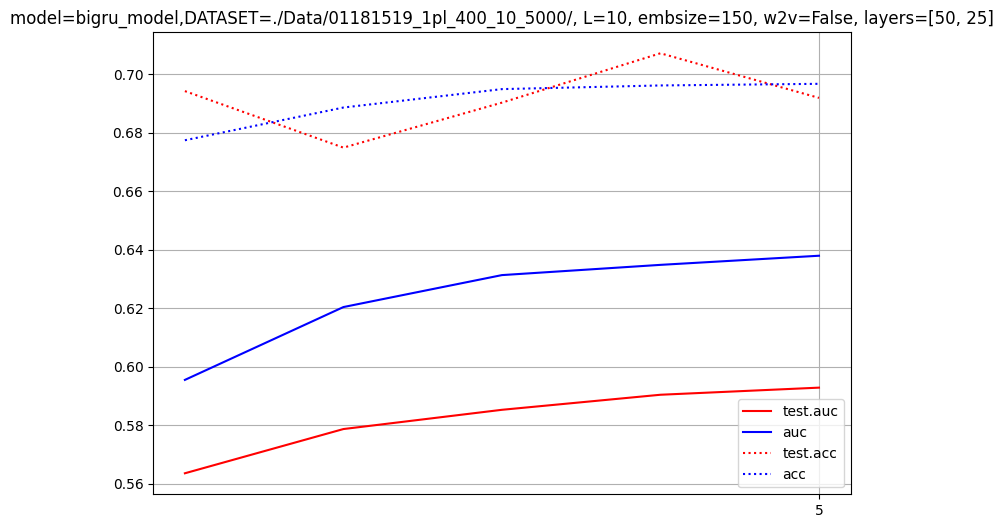

2356/2356 [==============================] - 13s 5ms/step
BiGru predictions
[[0.47584856]
 [0.6793486 ]
 [0.4476765 ]
 ...
 [0.23805131]
 [0.26051447]
 [0.239109  ]]
BiGru binary predictions
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
BiGru targets
[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]
 =============== START THE EXPERIMENT ============
~~~~~~~~~~~~~~~DATASET ./Data/01181519_1pl_400_10_5000/ ~~~~~~~~~~~
Number of skills: 10
Number of train students: 5000
Number of test students: 4636
(total: 9636)
!!exist!!
Baseline test accuracy = 0.3098561647470941
L = 10, emb_size = 150, hidden=[50, 25], spatial dropout = 0.5, gaussian dropout = 0.4
no model to delete
~~~~~~~~~~Train Bi-GRU MODEL~~~~~~~~
!!!!!!!!!!!! Using Random Skil name Embeddings!!!!
11
q before conv: (None, 10)
hist before conv: (None, 9)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected 

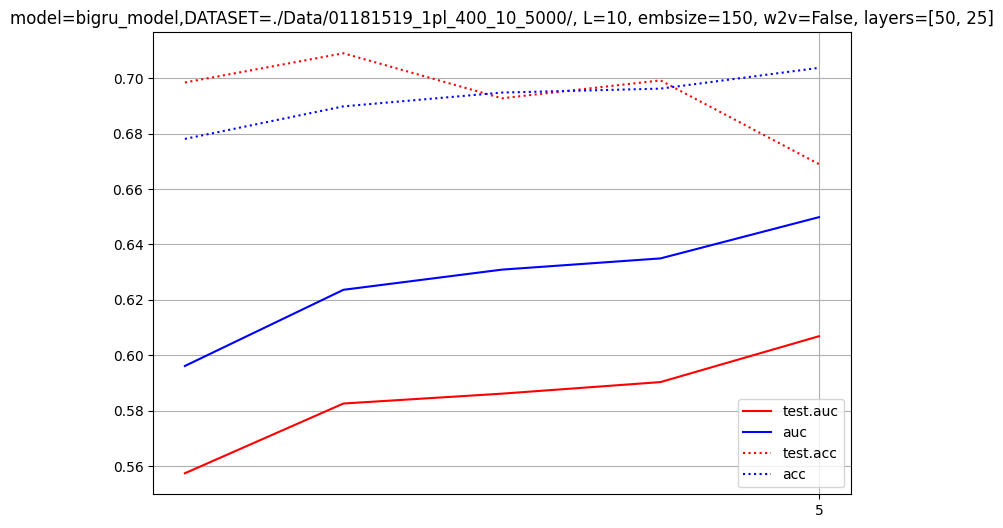

2356/2356 [==============================] - 22s 9ms/step
BiGru predictions
[[0.5816827 ]
 [0.64151967]
 [0.4872262 ]
 ...
 [0.21885596]
 [0.26408032]
 [0.23077346]]
BiGru binary predictions
[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
BiGru targets
[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]


In [30]:
# 先行研究
#BiGRU_main(file_path, skill_n)

# 比較研究
BiGRU_forget_main(file_path, skill_n, mode = "nonforget")

# 提案手法
BiGRU_forget_main(file_path, skill_n)

 =============== START THE EXPERIMENT ============
~~~~~~~~~~~~~~~DATASET ./Data/01181519_1pl_400_10_5000/ ~~~~~~~~~~~
Number of skills: 10
Number of train students: 5000
Number of test students: 4636
(total: 9636)
!!exist!!
Baseline test accuracy = 0.3098561647470941
L = 10, emb_size = 150, hidden=[50, 25], spatial dropout = 0.5, gaussian dropout = 0.4
no model to delete
~~~~~~~~~~Train Bi-GRU MODEL~~~~~~~~
!!!!!!!!!!!! Using Random Skil name Embeddings!!!!
11
q before conv: (None, 10)
hist before conv: (None, 9)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 9)]          0           []

C:\Users\S_Hasegawa\AppData\Local\Temp\ipykernel_14904\2474882828.py:141: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xticks(np.arange(0,max_epochs+1,5, dtype=np.int))
C:\Users\S_Hasegawa\AppData\Local\Temp\ipykernel_14904\2474882828.py:146: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


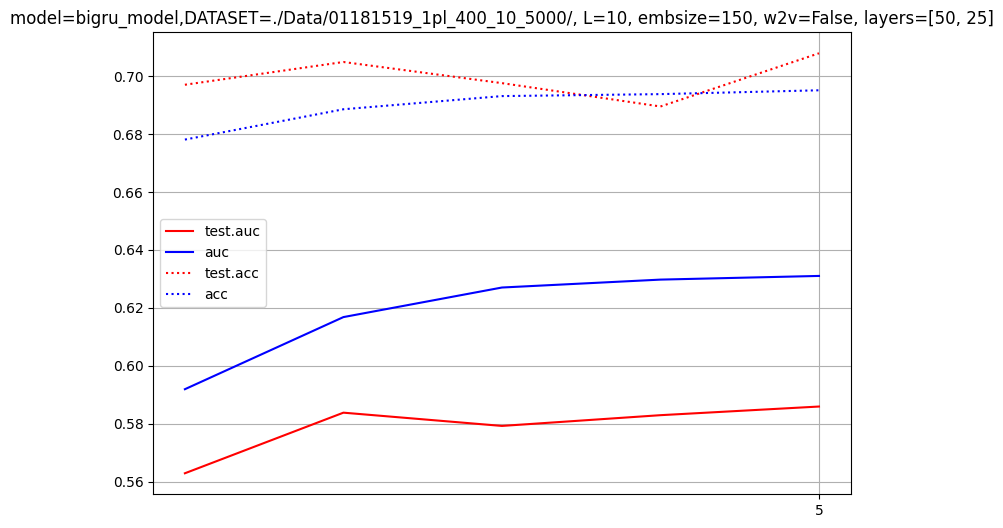

2356/2356 [==============================] - 26s 11ms/step
BiGru predictions
[[0.42166603]
 [0.4900436 ]
 [0.41635555]
 ...
 [0.23633707]
 [0.2571133 ]
 [0.26184344]]
BiGru binary predictions
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
BiGru targets
[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]


In [32]:
BiGRU_main(file_path, skill_n)